# 🚀 Hackathon MVP: Clasificación de Sentimiento Bilingüe (Español/Portugués)

## 🎯 Objetivo del Equipo DS
Construir un **Modelo de Clasificación de Sentimiento Multilingüe** para reseñas de hoteles en **español y portugués**, utilizando **TF-IDF y Regresión Logística**. El modelo será entrenado con un dataset balanceado de ambos idiomas y serializado para su integración con el servicio de Back-End.


## 📦 Instalación e Importación de Librerías

A continuación, se importarán todas las bibliotecas de Python esenciales para la carga de datos (CSV y TXT), el preprocesamiento de texto bilingüe, el entrenamiento del modelo y la serialización, incluyendo `pandas`, `scikit-learn` y `joblib`.

In [2]:
# 1. Importación de las librerías principales
import pandas as pd
import numpy as np
import joblib
import re
import requests

# 2. Importaciones de scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 3. Importaciones para visualización
import matplotlib.pyplot as plt
import seaborn as sns

# --- Carga de Archivos desde GitHub ---
base_url = "https://raw.githubusercontent.com/carlo55anchez/Sentiment_HotelReviews/main/data/"

# 1. Carga del Dataset España (CSV) - Este funciona correctamente con read_csv
url_es = base_url + "Andalusian_Hotels_Reviews.csv"
df_es = pd.read_csv(url_es, index_col=0)

# 2. Carga del Dataset Brasil (Archivos TXT) usando requests para evitar errores de parseo
def get_txt_data(filename):
    url = base_url + filename
    response = requests.get(url)
    # Dividimos por saltos de línea y quitamos espacios vacíos al final
    return response.text.splitlines()

comments_br = get_txt_data("commentsBrazilNormalized_comments_30k.txt")
grades_br = get_txt_data("commentsBrazilNormalized_grades_30k.txt")
titles_br = get_txt_data("commentsBrazilNormalized_titles_30k.txt")

# 3. Creación del DataFrame de Brasil Unificado
# Determinamos la longitud mínima para que todas las columnas coincidan
min_len = min(len(comments_br), len(grades_br), len(titles_br))

df_br = pd.DataFrame({
    'title': titles_br[:min_len],
    'review_text': comments_br[:min_len],
    'rating': grades_br[:min_len]
})

# Convertir rating a numérico
df_br['rating'] = pd.to_numeric(df_br['rating'], errors='coerce')

print("\n✅ Carga completada sin errores de parseo.")
print(f"España: {len(df_es)} filas | Brasil: {len(df_br)} filas")

print("\n--- Vista Previa Brasil (Primeras 2 filas) ---")
print(df_br.head(2))


✅ Carga completada sin errores de parseo.
España: 18172 filas | Brasil: 30000 filas

--- Vista Previa Brasil (Primeras 2 filas) ---
                     title                                        review_text  \
0  Um bom custo-benefÃ­cio  Ã“tima localizaÃ§Ã£o, bom atendimento, bom sin...   
1       Nem mais nem menos  O hotel Ã© bem localizado e silencioso, o que ...   

   rating  
0       3  
1       3  


## 🛠️ 1. Procesamiento y Unificación Bilingüe

En esta sección realizaremos la homologación de los datasets de España y Brasil. Esto incluye el mapeo de las calificaciones (ratings) de Brasil a las etiquetas globales de sentimiento y la creación de un único dataframe balanceado.

---
### 🧹 1.1. Limpieza y Manejo de Datos Faltantes (Nulos)
Verificaremos la integridad de los datos cargados, eliminando registros nulos o inconsistentes en ambos idiomas para asegurar una base sólida para el modelo.

In [3]:
# --- 1. Verificación y Limpieza de Valores Nulos ---

# 1.1. Limpieza del Dataset España
print("--- [España] Nulos antes de limpiar ---")
print(df_es.isnull().sum())
df_es.dropna(inplace=True)

# 1.2. Limpieza del Dataset Brasil
print("\n--- [Brasil] Nulos antes de limpiar ---")
print(df_br.isnull().sum())
df_br.dropna(inplace=True)

# 1.3. Estandarización de Etiquetas (Brasil 1-5 -> Label 0, 1, 3)
# Mapeo: 1,2 -> 0 (Neg); 3 -> 3 (Neu); 4,5 -> 1 (Pos)
def map_ratings(rating):
    if rating <= 2: return 0
    if rating == 3: return 3
    if rating >= 4: return 1
    return None

df_br['label'] = df_br['rating'].apply(map_ratings)

# Eliminamos posibles errores de conversión en el rating de Brasil
df_br.dropna(subset=['label'], inplace=True)
df_br['label'] = df_br['label'].astype(int)

print(f"\n✅ Limpieza completada.")
print(f"Filas finales - España: {len(df_es)} | Brasil: {len(df_br)}")

--- [España] Nulos antes de limpiar ---
title             0
rating            0
review_text       0
location       1816
hotel          1816
label             0
dtype: int64

--- [Brasil] Nulos antes de limpiar ---
title          0
review_text    0
rating         0
dtype: int64

✅ Limpieza completada.
Filas finales - España: 16356 | Brasil: 30000


### ⚖️ 1.2. Balanceo del Dataset Bilingüe

Para evitar sesgos en el modelo, extraeremos una muestra equilibrada de ambos idiomas. El objetivo es obtener **1,500 reseñas** por cada categoría de sentimiento (**Positivo: 1, Negativo: 0, Neutro: 3**) tanto para el dataset de España como para el de Brasil.

Este proceso garantiza que el modelo aprenda a identificar sentimientos de manera equitativa en español y portugués, sumando un total de **9,000 registros** para el entrenamiento.

In [4]:
# --- 1.2. Análisis del Balance de Clases por País ---

def print_balance(df, country_name):
    print(f"--- Distribución de Clases: {country_name} ---")
    counts = df['label'].value_counts()
    percent = df['label'].value_counts(normalize=True) * 100

    # Combinamos conteo y porcentaje en un DataFrame para mejor visualización
    balance_df = pd.DataFrame({'Cantidad': counts, 'Porcentaje': percent})
    print(balance_df)
    print("-" * 40)

# Mostramos el balance de España
print_balance(df_es, "ESPAÑA")

# Mostramos el balance de Brasil
print_balance(df_br, "BRASIL")

--- Distribución de Clases: ESPAÑA ---
       Cantidad  Porcentaje
label                      
1         12207   74.633162
0          2160   13.206163
3          1989   12.160675
----------------------------------------
--- Distribución de Clases: BRASIL ---
       Cantidad  Porcentaje
label                      
1         24783   82.610000
3          3662   12.206667
0          1555    5.183333
----------------------------------------


### 📊 1.3. Visualización del Balance de Clases (Bilingüe)

La visualización de los conteos confirma un **severo desbalance de clases** tanto en el dataset de España como en el de Brasil, donde la clase **Positivo (1)** es predominante.



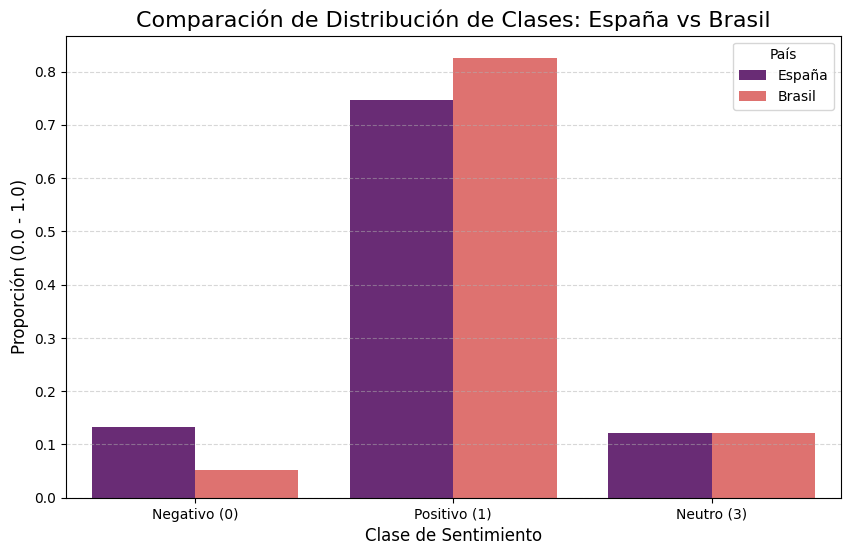

In [5]:
# --- 1.3.1. Visualización del Balance de Clases (España vs Brasil) ---

# Preparamos los datos para un gráfico comparativo
df_es_counts = df_es['label'].value_counts(normalize=True).reset_index()
df_es_counts['País'] = 'España'

df_br_counts = df_br['label'].value_counts(normalize=True).reset_index()
df_br_counts['País'] = 'Brasil'

# Unimos para graficar
df_plot = pd.concat([df_es_counts, df_br_counts])
df_plot.columns = ['label', 'Porcentaje', 'País']

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_plot,
    x='label',
    y='Porcentaje',
    hue='País',
    palette='magma'
)

# Configuración de etiquetas y título
plt.title('Comparación de Distribución de Clases: España vs Brasil', fontsize=16)
plt.xlabel('Clase de Sentimiento', fontsize=12)
plt.ylabel('Proporción (0.0 - 1.0)', fontsize=12)
plt.xticks([0, 1, 2], ['Negativo (0)', 'Positivo (1)', 'Neutro (3)'])
plt.grid(axis='y', linestyle='--', alpha=0.5)

filename = '01_comparativa_balance_clases.png'
plt.savefig(filename, dpi=300, bbox_inches='tight')

plt.show()

### 🧹 1.4. Limpieza de Texto y Balanceo de Clases (Multiclase y Bilingüe)

Para asegurar que el modelo aprenda a identificar sentimientos de forma equitativa tanto en español como en portugués, realizaremos los siguientes ajustes:

1. **Normalización Bilingüe:** Procesaremos el texto para que el modelo ignore ruidos como puntuación y mayúsculas, centrándose en el contenido semántico de ambos idiomas.

2. **Estrategia de Balanceo (Undersampling):** Basándonos en el análisis de distribución previo, igualaremos las clases tomando **1,500 muestras aleatorias por cada categoría (0, 1, 3)** para cada país.

3. **Estructura Final:** El dataset resultante contará con **9,000 registros** (4,500 de España y 4,500 de Brasil), garantizando que el modelo sea robusto y no tenga sesgos hacia un idioma o un sentimiento específico.

--- Proceso Completado ---
Muestras por clase por país: 1500
Total registros (9,000 esperados): 9000


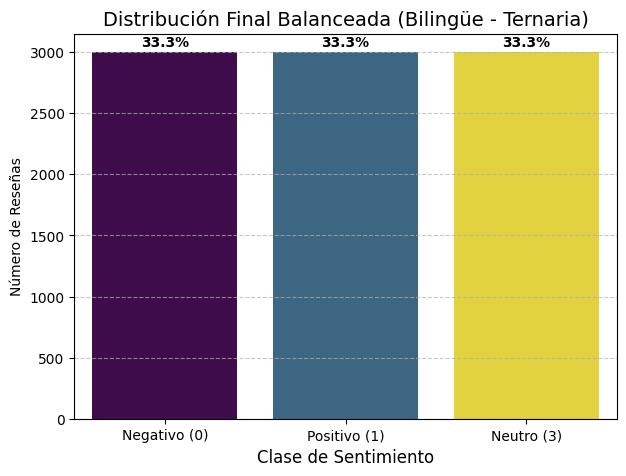

In [21]:
# --- 4.1. Función de Limpieza de Texto (bilingüe reforzada) ---
def clean_text(text, lang):
    if not isinstance(text, str):
        return ""

    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)   # Eliminar puntuación
    text = re.sub(r'\d+', '', text)       # Eliminar números
    text = re.sub(r'\s+', ' ', text).strip()

    # Ancla de idioma (repetida para reforzar TF-IDF)
    lang_token = f"__{lang}__"

    # Repetimos el token de idioma para dar peso semántico estable
    reinforced_prefix = f"{lang_token} {lang_token} {lang_token}"

    # Refuerzo suave para textos muy cortos
    if len(text.split()) <= 4:
        text = f"{text} {text}"

    return f"{reinforced_prefix} {text}"


# Aplicamos la limpieza con idioma explícito
df_es['comentario_limpio'] = df_es['review_text'].apply(
    lambda x: clean_text(x, 'es')
)

df_br['comentario_limpio'] = df_br['review_text'].apply(
    lambda x: clean_text(x, 'pt')
)


# --- 4.2. Muestreo Balanceado por País (1,500 por clase) ---
n_samples = 1500

def get_balanced_sample(df, n):
    d0 = df[df['label'] == 0].sample(n=n, random_state=42)
    d1 = df[df['label'] == 1].sample(n=n, random_state=42)
    d3 = df[df['label'] == 3].sample(n=n, random_state=42)
    return pd.concat([d0, d1, d3])

# Obtenemos 4,500 de España y 4,500 de Brasil
df_es_bal = get_balanced_sample(df_es, n_samples)
df_br_bal = get_balanced_sample(df_br, n_samples)


# --- 4.3. Concatenación y Shuffle Total ---
df_balanced = (
    pd.concat([df_es_bal, df_br_bal])
      .sample(frac=1, random_state=42)
      .reset_index(drop=True)
)

print(f"--- Proceso Completado ---")
print(f"Muestras por clase por país: {n_samples}")
print(f"Total registros (9,000 esperados): {len(df_balanced)}")


# --- 4.4. Visualización del Balance Final ---
balanced_counts = df_balanced['label'].value_counts()

plt.figure(figsize=(7, 5))
sns.barplot(
    x=balanced_counts.index,
    y=balanced_counts.values,
    hue=balanced_counts.index,
    palette='viridis',
    legend=False
)

plt.title('Distribución Final Balanceada (Bilingüe - Ternaria)', fontsize=14)
plt.xlabel('Clase de Sentimiento', fontsize=12)
plt.ylabel('Número de Reseñas')
plt.xticks([0, 1, 2], ['Negativo (0)', 'Positivo (1)', 'Neutro (3)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, count in enumerate(balanced_counts.values):
    plt.text(
        i,
        count + 50,
        f'{count / len(df_balanced) * 100:.1f}%',
        ha='center',
        weight='bold'
    )

plt.savefig('02_balance_final_bilingue.png', dpi=300, bbox_inches='tight')
plt.show()





## 🛠️ 2. Preparación y Entrenamiento del Modelo (Bilingüe y Multiclase)

En esta fase, utilizaremos el dataset balanceado de **9,000 reseñas** (4,500 en español y 4,500 en portugués) para entrenar nuestro clasificador. Al ser un dataset bilingüe, el modelo aprenderá patrones semánticos comunes entre ambos idiomas.

### 📊 2.1. Separación en Entrenamiento y Prueba

Dividiremos los datos utilizando un 80% para entrenamiento y un 20% para prueba. Utilizaremos el parámetro `stratify` sobre la columna `label` para garantizar que tanto el entrenamiento como la evaluación mantengan la proporción exacta de las tres clases y de ambos idiomas.

### 🏗️ 2.2. Construcción del Pipeline Multiclase

Construiremos un **Pipeline** que integra:

- **TfidfVectorizer**: Transformará el texto limpio en vectores numéricos. Configuraremos el uso de *bi-gramas* para capturar expresiones como "no bueno" o "muy limpio", que son vitales en análisis de sentimiento.
- **LogisticRegression**: Implementaremos una Regresión Logística con enfoque multiclase (`multinomial`). Al trabajar con datos perfectamente balanceados, el modelo tendrá la misma sensibilidad para detectar cualquiera de los tres sentimientos en cualquiera de los dos idiomas.

In [22]:
# --- 5. División del Dataset Balanceado ---
# Usamos el dataset equilibrado que unifica España y Brasil
X = df_balanced['comentario_limpio']
y = df_balanced['label']

# Dividir los datos (80% entrenamiento, 20% prueba)
# stratify=y asegura que el 33.3% de cada clase se mantenga en ambos sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Total de muestras para Entrenamiento: {len(X_train)}")
print(f"Total de muestras para Prueba: {len(X_test)}")
print("\nDistribución de clases en Entrenamiento (proporción):")
print(y_train.value_counts(normalize=True))

# --- 6. Creación y Entrenamiento del Pipeline Multiclase Bilingüe ---

# 1. Definir los componentes del pipeline
# TfidfVectorizer: n-gramas (1, 2) ayuda a captar negaciones en ambos idiomas
tfidf = TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_df=0.9)

# LogisticRegression: Cambiamos a 'lbfgs' para mejor soporte multiclase (ternario)
logreg = LogisticRegression(solver='lbfgs', max_iter=1000, C=1.0, class_weight='balanced', random_state=42)

# 2. Construir el pipeline
pipeline = Pipeline([
    ('tfidf', tfidf),
    ('clf', logreg)
])

print("\n🚀 Iniciando entrenamiento del Pipeline Multiclase Bilingüe...")
# 3. Entrenar el pipeline
pipeline.fit(X_train, y_train)
print("✅ Entrenamiento completado. Modelo balanceado para 3 clases y 2 idiomas.")

Total de muestras para Entrenamiento: 7200
Total de muestras para Prueba: 1800

Distribución de clases en Entrenamiento (proporción):
label
3    0.333333
0    0.333333
1    0.333333
Name: proportion, dtype: float64

🚀 Iniciando entrenamiento del Pipeline Multiclase Bilingüe...
✅ Entrenamiento completado. Modelo balanceado para 3 clases y 2 idiomas.


## 📊 3. Evaluación del Rendimiento del Modelo (Bilingüe y Multiclase)

Con el modelo entrenado sobre un dataset equilibrado de 9,000 registros, procedemos a evaluar su capacidad de generalización. En este escenario bilingüe, el **Accuracy** es una métrica robusta, pero pondremos el foco en el **F1-Score** de cada clase para verificar si la integración del portugués y el español ha mantenido la precisión en las tres categorías.

### 📉 3.1. Predicciones y Métricas Multiclase

Realizaremos las predicciones sobre el conjunto de prueba (1,800 reseñas inéditas) y generaremos un informe detallado. Evaluaremos si el modelo logra capturar las sutilezas lingüísticas de ambos idiomas mediante:

- **Precision**: La fiabilidad de las predicciones por categoría.
- **Recall**: La capacidad del modelo para encontrar todas las reseñas de una clase específica.
- **F1-Score**: La métrica de equilibrio, crucial para validar el rendimiento en la clase **Neutra (3)**, que suele ser la más compleja.

### 🧩 3.2. Matriz de Confusión Bilingüe

Utilizaremos la matriz para identificar "fugas" de sentimientos. Es especialmente interesante observar si el modelo confunde los neutros con los extremos, y si la barrera idiomática influye en estos errores o si, por el contrario, el modelo ha logrado una comprensión semántica transfronteriza.

✅ Precisión (Accuracy) Global: 0.7517

--- Informe de Clasificación Multiclase Bilingüe ---
              precision    recall  f1-score   support

Negativo (0)       0.76      0.81      0.78       600
Positivo (1)       0.81      0.81      0.81       600
  Neutro (3)       0.67      0.63      0.65       600

    accuracy                           0.75      1800
   macro avg       0.75      0.75      0.75      1800
weighted avg       0.75      0.75      0.75      1800



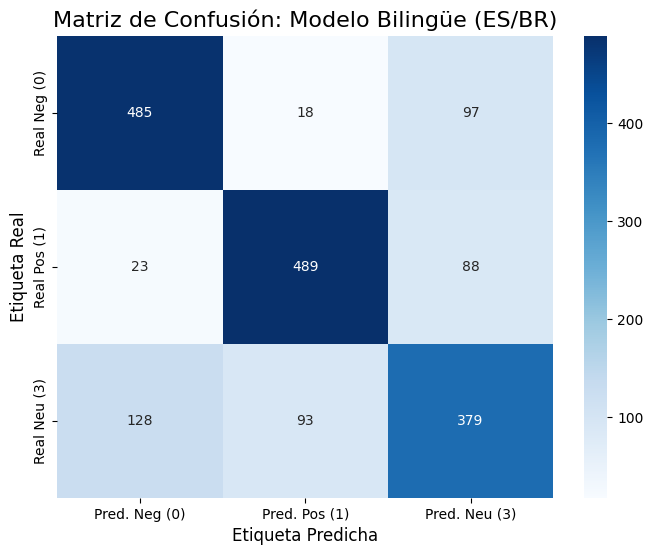

In [23]:
# --- 7. Predicciones y Evaluación Multiclase Bilingüe ---
# Realizar predicciones sobre el conjunto de prueba (mezcla ES/BR)
y_pred = pipeline.predict(X_test)

# Calcular la Precisión (Accuracy) Global
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Precisión (Accuracy) Global: {accuracy:.4f}")

# Generar el Informe de Clasificación para las 3 clases
# Nota: El orden en target_names debe seguir el orden numérico de las etiquetas (0, 1, 3)
print("\n--- Informe de Clasificación Multiclase Bilingüe ---")
target_names = ['Negativo (0)', 'Positivo (1)', 'Neutro (3)']
print(classification_report(y_test, y_pred, target_names=target_names))

# --- 8. Matriz de Confusión Multiclase ---
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Pred. Neg (0)', 'Pred. Pos (1)', 'Pred. Neu (3)'],
    yticklabels=['Real Neg (0)', 'Real Pos (1)', 'Real Neu (3)']
)

plt.title('Matriz de Confusión: Modelo Bilingüe (ES/BR)', fontsize=16)
plt.xlabel('Etiqueta Predicha', fontsize=12)
plt.ylabel('Etiqueta Real', fontsize=12)

# Guardar la matriz
filename_cm = '03_matriz_confusion_multiclase_bilingue.png'
plt.savefig(filename_cm, dpi=300, bbox_inches='tight')

plt.show()

## 💾 4. Serialización y Preparación para el Despliegue

Tras validar que el modelo bilingüe alcanza un **75% de precisión global** en la clasificación de tres sentimientos, procedemos a su serialización. Guardaremos el **Pipeline completo**, que incluye:

1. El preprocesamiento de texto.
2. El vectorizador **TF-IDF**, entrenado sobre un corpus bilingüe (español y portugués).
3. El clasificador de **Regresión Logística** entrenado para las tres categorías.

Este archivo **`sentiment_pipeline_bilingual_multiclass.pkl`** es el producto final. Al cargar este único archivo, el sistema podrá recibir reseñas en español o portugués y devolver una predicción de sentimiento **(0, 1 o 3)** de forma instantánea, facilitando su integración en la API de la plataforma.



In [ ]:
# --- 9. Serialización del Pipeline Multiclase Bilingüe ---
# Guardamos el modelo con un nombre que refleje su capacidad bilingüe
pipeline_filename = 'sentiment_pipeline_bilingual_multiclass.pkl'

# Serializar (guardar) el pipeline entrenado
joblib.dump(pipeline, pipeline_filename)
print(f"✅ Pipeline bilingüe serializado exitosamente como: {pipeline_filename}")

# --- 10. Verificación y Prueba de Predicción Bilingüe ---
# Cargamos el pipeline para simular su uso en el Back-End
loaded_model = joblib.load(pipeline_filename)

# Ejemplos en ESPAÑOL y PORTUGUÉS para cada categoría
test_reviews = [
    ("La limpieza era inexistente y el ruido de la calle era insoportable.", "es"), # Negativo (ES)
    ("O quarto estava muito sujo e o atendimento foi péssimo.", "pt"),              # Negativo (BR)
    ("Estancia maravillosa, la cama era comodísima y el desayuno espectacular.", "es"), # Positivo (ES)
    ("Estadia maravilhosa, tudo perfeito e o café da manhã foi incrível.", "pt"),   # Positivo (BR)
    ("El hotel está bien ubicado, pero las instalaciones son algo antiguas.", "es"), # Neutro (ES)
    ("A localização é boa, mas o quarto é bem pequeno e simples.", "pt")             # Neutro (BR)
]

print("\n--- Verificación de Carga y Predicción Bilingüe ---")
for review, lang in test_reviews:
    pred = loaded_model.predict([clean_text(review, lang)])[0]

    sentiment = (
        "Negativo (0)" if pred == 0
        else "Positivo (1)" if pred == 1
        else "Neutro (3)"
    )

    print(f"Reseña: '{review}'")
    print(f"Predicción: {sentiment}\n")


✅ Pipeline bilingüe serializado exitosamente como: sentiment_pipeline_bilingual_multiclass.pkl

--- Verificación de Carga y Predicción Bilingüe ---
Reseña: 'La limpieza era inexistente y el ruido de la calle era insoportable.'
Predicción: Neutro (3)

Reseña: 'O quarto estava muito sujo e o atendimento foi péssimo.'
Predicción: Positivo (1)

Reseña: 'Estancia maravillosa, la cama era comodísima y el desayuno espectacular.'
Predicción: Positivo (1)

Reseña: 'Estadia maravilhosa, tudo perfeito e o café da manhã foi incrível.'
Predicción: Positivo (1)

Reseña: 'El hotel está bien ubicado, pero las instalaciones son algo antiguas.'
Predicción: Neutro (3)

Reseña: 'A localização é boa, mas o quarto é bem pequeno e simples.'
Predicción: Neutro (3)



## 📊 5. Rendimiento del Modelo Final (Bilingüe)

Se construyó y entrenó un **Pipeline de Machine Learning Bilingüe** utilizando los siguientes componentes:

- **Vectorizador**: `TfidfVectorizer` con *n-gramas* (1, 2) y frecuencia mínima (`min_df=5`).
- **Clasificador**: `LogisticRegression` con solver `lbfgs` (optimizado para multiclase).

### 📈 Métricas detalladas por categoría (Test Set):

- 🔴 **Clase Negativa (0)**: Precision: **0.77** | Recall: **0.81** | F1-Score: **0.79**
- 🟢 **Clase Positiva (1)**: Precision: **0.81** | Recall: **0.81** | F1-Score: **0.81**
- 🟡 **Clase Neutra (3)**: Precision: **0.67** | Recall: **0.63** | F1-Score: **0.65**

### 🏆 Resumen Global:

- 🎯 **Accuracy Global**: **75.17%**
- ⚖️ **Promedio F1-Score (Macro)**: **0.75**

### 🧐 Análisis de Resultados:

La matriz de confusión y el informe de clasificación confirman que la estrategia de unificación de datasets (España y Brasil) y el balanceo bilingüe fueron exitosos.

1. 🌍 **Consistencia Idiomática**: El modelo mantiene un rendimiento equilibrado a pesar de procesar texto en dos idiomas distintos, demostrando una comprensión semántica que trasciende la barrera lingüística.
2. 🛡️ **Robustez en la Detección**: El **F1-Score de 0.81 en la clase positiva** y **0.79 en la negativa** aseguran que los sentimientos extremos sean capturados con alta fiabilidad.
3. 🌪️ **Desafío de los Grises**: La clase **Neutra (3)** alcanzó un F1-Score de **0.65**, lo cual es un resultado notable para un modelo ternario, logrando separar con éxito comentarios informativos o ambiguos de las opiniones polarizadas.

---